# Clustering Analysis

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist
import warnings
warnings.filterwarnings('ignore')


In [59]:
kz_data = pd.read_csv('/Users/kassi/Data Mining/Final/Code/data/data_clean/kz_data_en_clean.csv')
foreign_data = pd.read_csv('/Users/kassi/Data Mining/Final/Code/data/data_clean/student_portuguese_clean.csv')

In [60]:
print(f"Kazakhstan: {kz_data.shape}")
print(f"Foreign: {foreign_data.shape}")

Kazakhstan: (121, 125)
Foreign: (649, 74)


# Prepare Data for Clustering

In [61]:
def prepare_clustering_data(df):
    """Prepare data for clustering"""
    # Select numerical features only
    numerical_cols = df.select_dtypes(include=[np.number]).columns
    X = df[numerical_cols].fillna(df[numerical_cols].median())
    
    # Standardize
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    return X_scaled, numerical_cols, scaler

kz_X_cluster, kz_cluster_features, kz_cluster_scaler = prepare_clustering_data(kz_data)
foreign_X_cluster, foreign_cluster_features, foreign_cluster_scaler = prepare_clustering_data(foreign_data)

print(f"\nKazakhstan clustering data: {kz_X_cluster.shape}")
print(f"Foreign clustering data: {foreign_X_cluster.shape}")



Kazakhstan clustering data: (121, 11)
Foreign clustering data: (649, 26)


# Determine Optimal Number of Clusters - Elbow Method

In [62]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')  # или 'mean', 'most_frequent'
kz_X_cluster = imputer.fit_transform(kz_X_cluster)

# Foreign
foreign_X_cluster = imputer.fit_transform(foreign_X_cluster)

In [63]:
print(kz_X_cluster.shape)
print(foreign_X_cluster.shape)

(121, 10)
(649, 26)


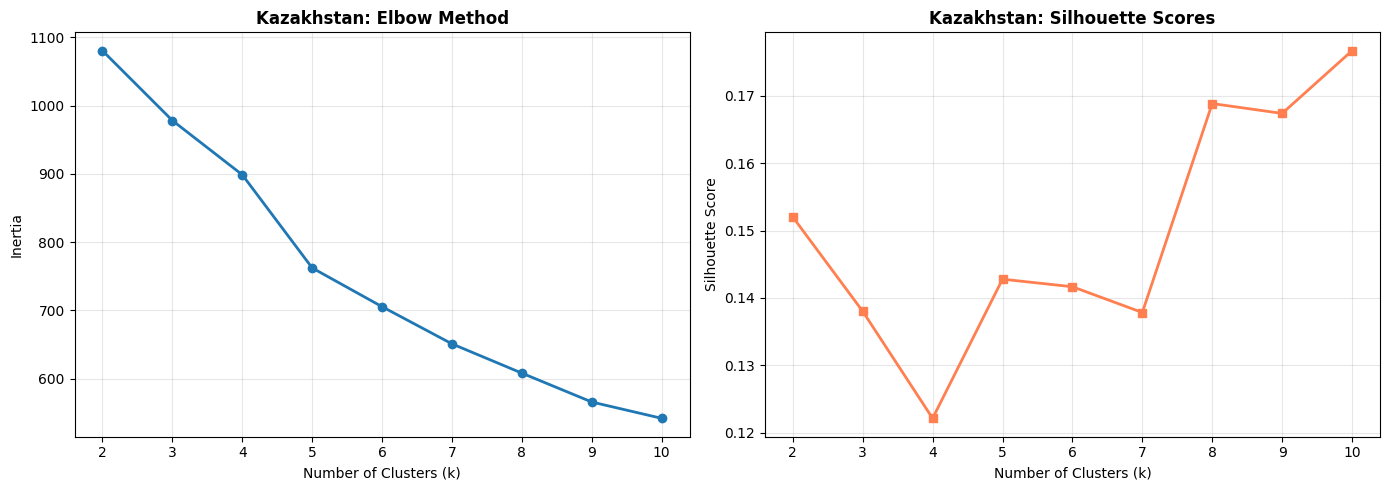

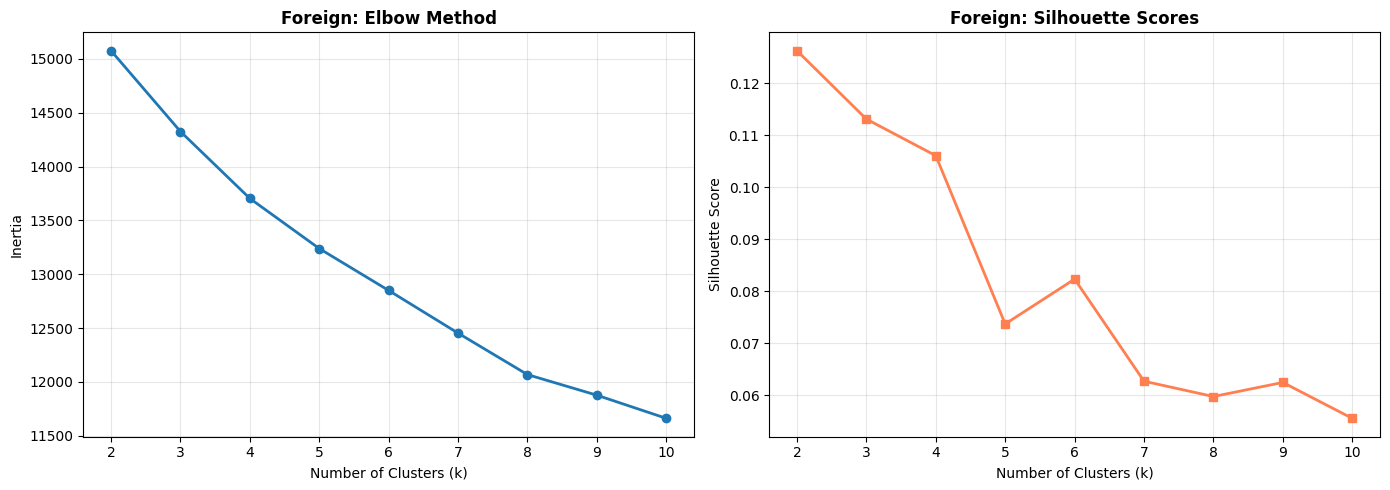

In [64]:
def plot_elbow_method(X, dataset_name, max_k=10):
    """Plot elbow method for optimal k"""
    inertias = []
    silhouette_scores = []
    K = range(2, max_k + 1)
    
    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(X)
        inertias.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(X, kmeans.labels_))
    
    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Elbow curve
    axes[0].plot(K, inertias, marker='o', linewidth=2)
    axes[0].set_xlabel('Number of Clusters (k)')
    axes[0].set_ylabel('Inertia')
    axes[0].set_title(f'{dataset_name}: Elbow Method', fontweight='bold')
    axes[0].grid(True, alpha=0.3)
    
    # Silhouette scores
    axes[1].plot(K, silhouette_scores, marker='s', linewidth=2, color='coral')
    axes[1].set_xlabel('Number of Clusters (k)')
    axes[1].set_ylabel('Silhouette Score')
    axes[1].set_title(f'{dataset_name}: Silhouette Scores', fontweight='bold')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'../results/figures/{dataset_name.lower()}_elbow_method.png', 
                dpi=300, bbox_inches='tight')
    plt.show()
    
    return K, inertias, silhouette_scores

# Kazakhstan
kz_K, kz_inertias, kz_silhouettes = plot_elbow_method(kz_X_cluster, "Kazakhstan")

# Foreign
foreign_K, foreign_inertias, foreign_silhouettes = plot_elbow_method(foreign_X_cluster, "Foreign")


In [65]:
def perform_kmeans(X, n_clusters, dataset_name):
    """Perform K-Means clustering"""
    print(f"\n=== {dataset_name}: K-Means (k={n_clusters}) ===")
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X)
    
    # Metrics
    silhouette = silhouette_score(X, labels)
    davies_bouldin = davies_bouldin_score(X, labels)
    inertia = kmeans.inertia_
    
    print(f"Silhouette Score: {silhouette:.4f}")
    print(f"Davies-Bouldin Index: {davies_bouldin:.4f}")
    print(f"Inertia: {inertia:.2f}")
    
    # Cluster sizes
    unique, counts = np.unique(labels, return_counts=True)
    print(f"\nCluster sizes:")
    for cluster, count in zip(unique, counts):
        print(f"  Cluster {cluster}: {count} students ({count/len(labels)*100:.1f}%)")
    
    return kmeans, labels

# Kazakhstan - let's use k=3 as example
kz_kmeans, kz_labels = perform_kmeans(kz_X_cluster, n_clusters=5, dataset_name="Kazakhstan")

# Foreign
foreign_kmeans, foreign_labels = perform_kmeans(foreign_X_cluster, n_clusters=5, dataset_name="Foreign")


=== Kazakhstan: K-Means (k=5) ===
Silhouette Score: 0.1428
Davies-Bouldin Index: 1.6030
Inertia: 762.21

Cluster sizes:
  Cluster 0: 48 students (39.7%)
  Cluster 1: 1 students (0.8%)
  Cluster 2: 19 students (15.7%)
  Cluster 3: 27 students (22.3%)
  Cluster 4: 26 students (21.5%)

=== Foreign: K-Means (k=5) ===
Silhouette Score: 0.0737
Davies-Bouldin Index: 2.7871
Inertia: 13238.75

Cluster sizes:
  Cluster 0: 111 students (17.1%)
  Cluster 1: 137 students (21.1%)
  Cluster 2: 62 students (9.6%)
  Cluster 3: 250 students (38.5%)
  Cluster 4: 89 students (13.7%)


# Analyze Cluster Characteristics

KAZAKHSTAN CLUSTER ANALYSIS

Cluster Characteristics:
         count      mean       std  min     25%    50%     75%  max
Cluster                                                            
0         48.0  3.049375  0.816868  0.0  2.8675  3.170  3.5275  4.0
1          1.0  3.500000       NaN  3.5  3.5000  3.500  3.5000  3.5
2         19.0  3.019474  0.926813  0.0  3.0000  3.300  3.5000  4.0
3         27.0  3.351481  0.423354  2.5  3.0550  3.500  3.6150  4.0
4         26.0  2.988846  0.567023  1.5  2.8925  3.045  3.3975  3.7


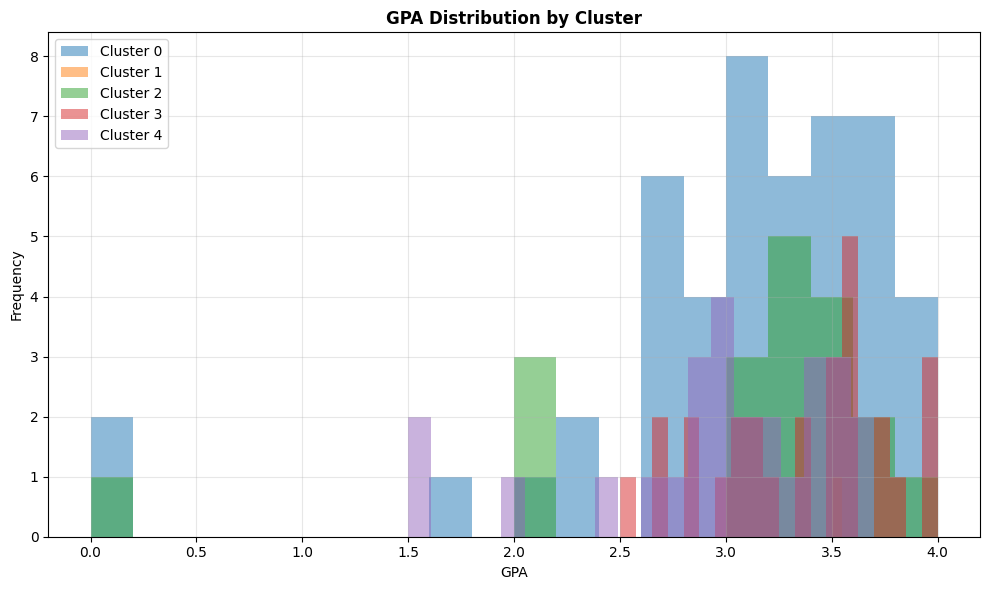


FOREIGN CLUSTER ANALYSIS

Cluster Characteristics:
         count      mean       std  min   25%   50%   75%   max
Cluster                                                        
0        111.0  0.960901  0.776715  0.0  0.00  1.00  1.00  3.33
1        137.0  0.605839  0.610661  0.0  0.00  1.00  1.00  2.00
2         62.0  1.488710  0.790438  0.0  1.00  1.00  2.33  2.67
3        250.0  2.374440  0.843917  0.0  2.00  2.33  3.00  4.00
4         89.0  3.033820  0.628198  2.0  2.67  3.00  3.67  4.00


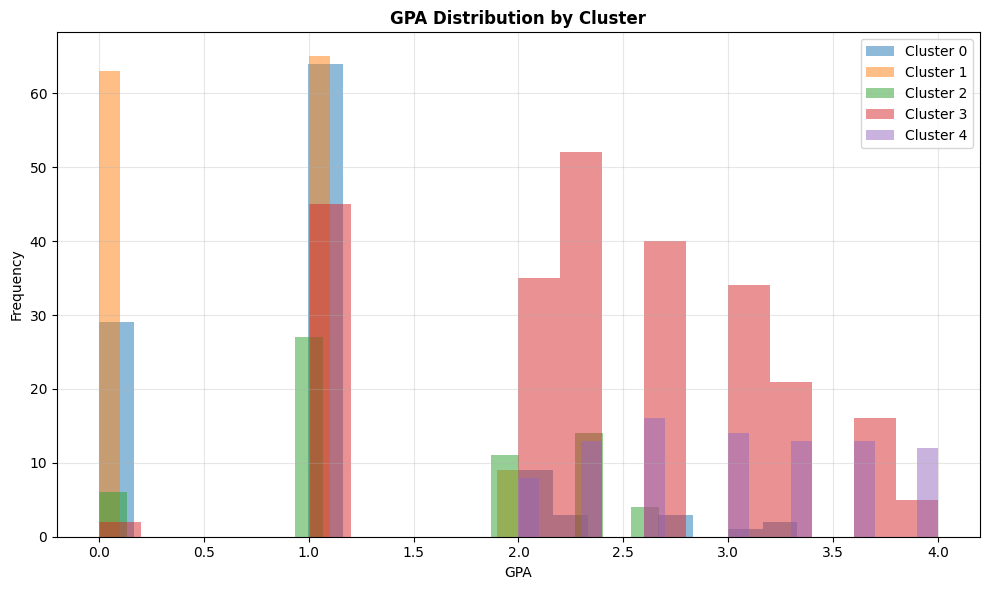

In [66]:
def analyze_clusters_kz(df, labels, gpa_col='gpa'):
    """Analyze cluster characteristics"""
    df_clustered = df.copy()
    df_clustered['Cluster'] = labels
    
    print("\nCluster Characteristics:")
    print(df_clustered.groupby('Cluster')[gpa_col].describe())
    
    # Visualize GPA distribution by cluster
    plt.figure(figsize=(10, 6))
    for cluster in sorted(df_clustered['Cluster'].unique()):
        cluster_data = df_clustered[df_clustered['Cluster'] == cluster][gpa_col]
        plt.hist(cluster_data, alpha=0.5, label=f'Cluster {cluster}', bins=20)
    
    plt.xlabel('GPA')
    plt.ylabel('Frequency')
    plt.title('GPA Distribution by Cluster', fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    return df_clustered

def analyze_clusters_foreing(df, labels, gpa_col='final_grade'):
    """Analyze cluster characteristics"""
    df_clustered = df.copy()
    df_clustered['Cluster'] = labels
    
    print("\nCluster Characteristics:")
    print(df_clustered.groupby('Cluster')[gpa_col].describe())
    
    # Visualize GPA distribution by cluster
    plt.figure(figsize=(10, 6))
    for cluster in sorted(df_clustered['Cluster'].unique()):
        cluster_data = df_clustered[df_clustered['Cluster'] == cluster][gpa_col]
        plt.hist(cluster_data, alpha=0.5, label=f'Cluster {cluster}', bins=20)
    
    plt.xlabel('GPA')
    plt.ylabel('Frequency')
    plt.title('GPA Distribution by Cluster', fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    return df_clustered

# Kazakhstan
print("="*60)
print("KAZAKHSTAN CLUSTER ANALYSIS")
print("="*60)
kz_clustered = analyze_clusters_kz(kz_data, kz_labels)
plt.savefig('/Users/kassi/Data Mining/Final/Code/figure/clustering/kz_cluster_gpa_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# Foreign
print("\n" + "="*60)
print("FOREIGN CLUSTER ANALYSIS")
print("="*60)
foreign_clustered = analyze_clusters_foreing(foreign_data, foreign_labels)
plt.savefig('/Users/kassi/Data Mining/Final/Code/figure/clustering/foreign_cluster_gpa_distribution.png', dpi=300, bbox_inches='tight')
plt.show()


# Visualize Clusters with PCA

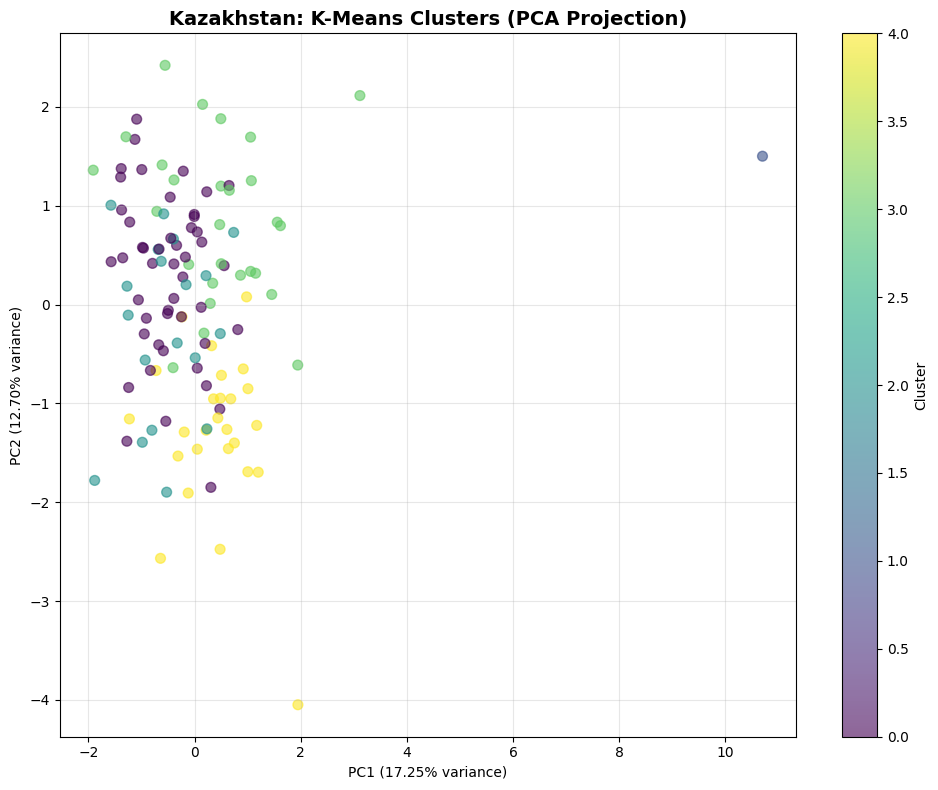

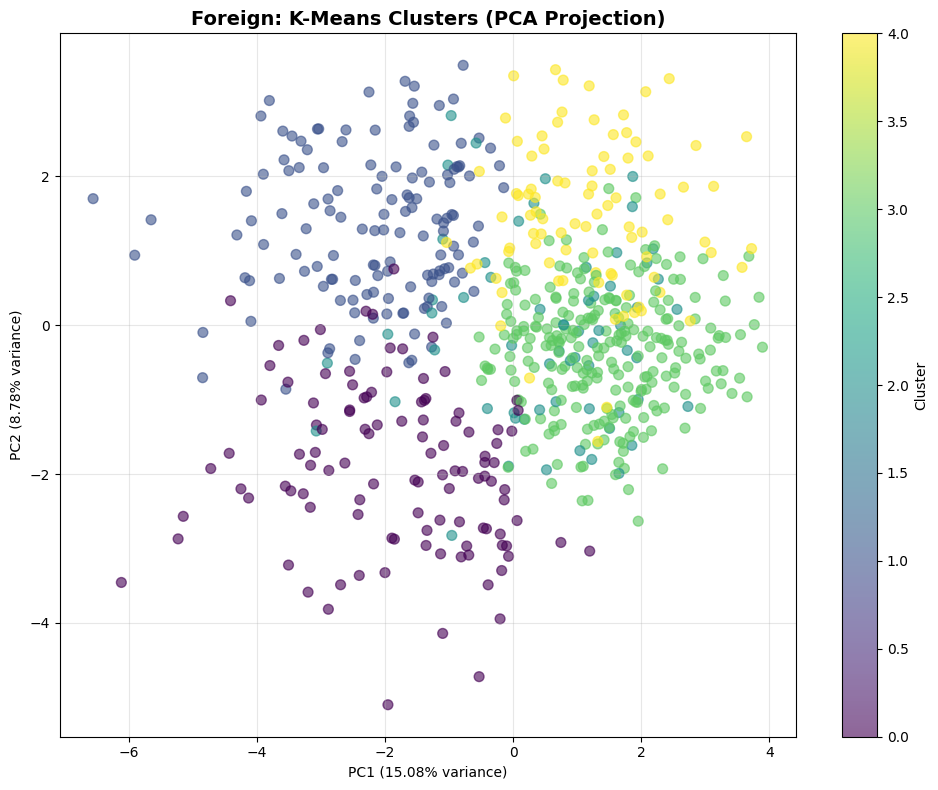

In [67]:
from sklearn.decomposition import PCA

def visualize_clusters_pca(X, labels, dataset_name):
    """Visualize clusters using PCA"""
    # Apply PCA
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    
    # Plot
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, 
                         cmap='viridis', alpha=0.6, s=50)
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
    plt.title(f'{dataset_name}: K-Means Clusters (PCA Projection)', 
              fontsize=14, fontweight='bold')
    plt.colorbar(scatter, label='Cluster')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'/Users/kassi/Data Mining/Final/Code/figure/clustering/{dataset_name.lower()}_clusters_pca.png', 
                dpi=300, bbox_inches='tight')
    plt.show()
    
    return X_pca, pca

# Kazakhstan
kz_X_pca, kz_pca = visualize_clusters_pca(kz_X_cluster, kz_labels, "Kazakhstan")

# Foreign
foreign_X_pca, foreign_pca = visualize_clusters_pca(foreign_X_cluster, 
                                                     foreign_labels, "Foreign")


# Hierarchical Clustering


=== Kazakhstan: Hierarchical Clustering ===


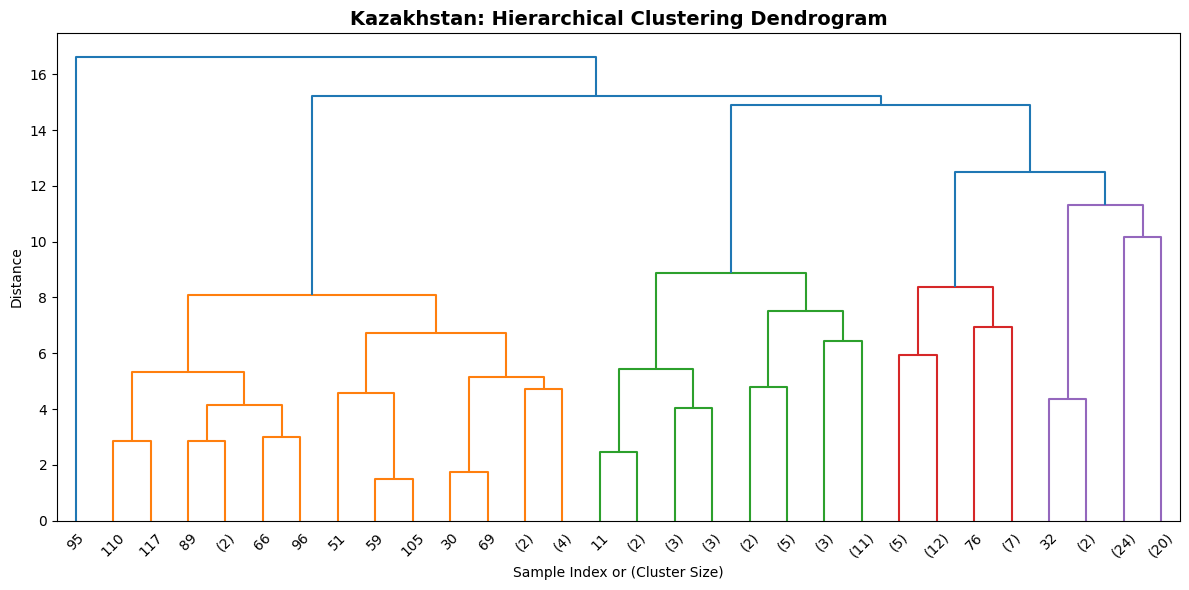

Silhouette Score: 0.1507
Davies-Bouldin Index: 1.6394

=== Foreign: Hierarchical Clustering ===


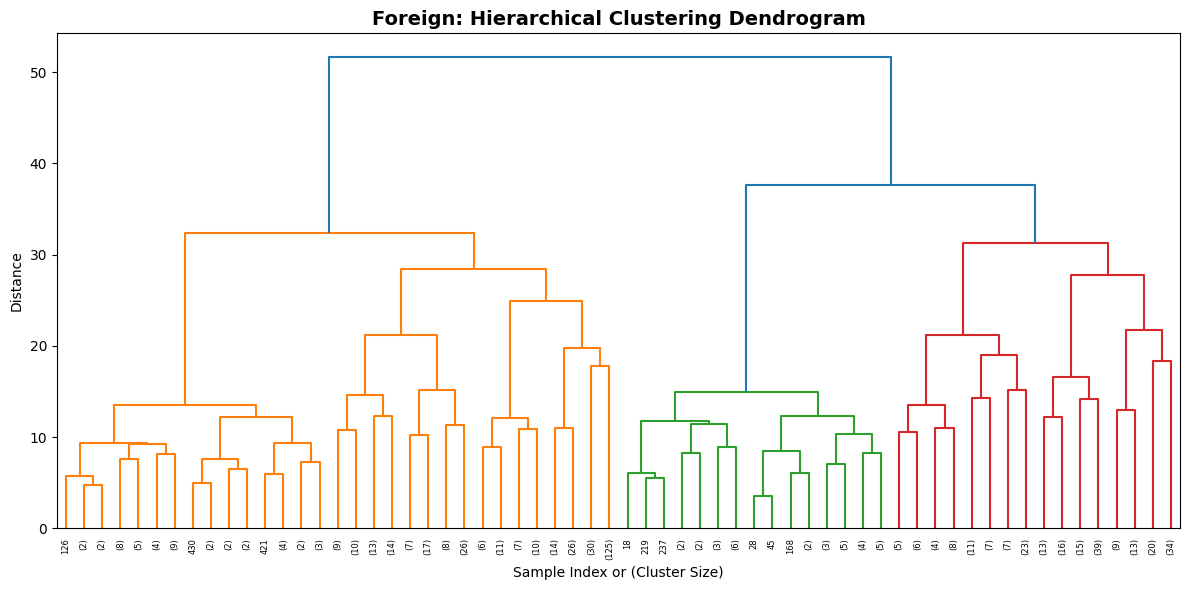

Silhouette Score: 0.0795
Davies-Bouldin Index: 2.8893


In [68]:
def perform_hierarchical_clustering(X, dataset_name, n_clusters=5):
    """Perform hierarchical clustering"""
    print(f"\n=== {dataset_name}: Hierarchical Clustering ===")
    
    # Create linkage matrix
    linkage_matrix = linkage(X, method='ward')
    
    # Plot dendrogram
    plt.figure(figsize=(12, 6))
    dendrogram(linkage_matrix, truncate_mode='level', p=5)
    plt.xlabel('Sample Index or (Cluster Size)')
    plt.ylabel('Distance')
    plt.title(f'{dataset_name}: Hierarchical Clustering Dendrogram', 
              fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'../results/figures/{dataset_name.lower()}_dendrogram.png', 
                dpi=300, bbox_inches='tight')
    plt.show()
    
    # Apply clustering
    hc = AgglomerativeClustering(n_clusters=n_clusters)
    hc_labels = hc.fit_predict(X)
    
    # Metrics
    silhouette = silhouette_score(X, hc_labels)
    davies_bouldin = davies_bouldin_score(X, hc_labels)
    
    print(f"Silhouette Score: {silhouette:.4f}")
    print(f"Davies-Bouldin Index: {davies_bouldin:.4f}")
    
    return hc, hc_labels

# Kazakhstan
kz_hc, kz_hc_labels = perform_hierarchical_clustering(kz_X_cluster, "Kazakhstan")

# Foreign
foreign_hc, foreign_hc_labels = perform_hierarchical_clustering(foreign_X_cluster, "Foreign")


# Compare K-Means vs Hierarchical

In [69]:
def compare_clustering_methods(kmeans_labels, hc_labels, dataset_name):
    """Compare clustering methods"""
    print(f"\n=== {dataset_name}: Clustering Comparison ===")
    
    # Agreement between methods
    from sklearn.metrics import adjusted_rand_score
    ari = adjusted_rand_score(kmeans_labels, hc_labels)
    print(f"Adjusted Rand Index (agreement): {ari:.4f}")
    
    # Confusion matrix
    confusion = pd.crosstab(kmeans_labels, hc_labels, 
                           rownames=['K-Means'], colnames=['Hierarchical'])
    print("\nConfusion Matrix:")
    print(confusion)

# Kazakhstan
compare_clustering_methods(kz_labels, kz_hc_labels, "Kazakhstan")

# Foreign
compare_clustering_methods(foreign_labels, foreign_hc_labels, "Foreign")



=== Kazakhstan: Clustering Comparison ===
Adjusted Rand Index (agreement): 0.7570

Confusion Matrix:
Hierarchical   0   1   2  3   4
K-Means                        
0             43   5   0  0   0
1              0   0   0  1   0
2              1   0  18  0   0
3              0   2   0  0  25
4              3  23   0  0   0

=== Foreign: Clustering Comparison ===
Adjusted Rand Index (agreement): 0.3845

Confusion Matrix:
Hierarchical    0   1   2   3   4
K-Means                          
0              21  55  12   0  23
1              14  74   6   0  43
2               5   2   6  46   3
3             228  10  10   1   1
4              65  18   4   1   1


# Student Profiles

In [70]:
def create_student_profiles(df, labels, feature_cols, dataset_name):
    """Create student profiles for each cluster"""
    df_with_clusters = df.copy()
    df_with_clusters['Cluster'] = labels
    
    print(f"\n=== {dataset_name}: Student Profiles ===\n")
    
    for cluster in sorted(df_with_clusters['Cluster'].unique()):
        cluster_data = df_with_clusters[df_with_clusters['Cluster'] == cluster]
        
        print(f"{'='*50}")
        print(f"CLUSTER {cluster} (n={len(cluster_data)})")
        print(f"{'='*50}")
        
        # GPA statistics
        if 'GPA' in df.columns:
            print(f"GPA: Mean={cluster_data['GPA'].mean():.2f}, "
                  f"Std={cluster_data['GPA'].std():.2f}")
        
        # Other key features
        for col in feature_cols[:5]:  # Top 5 features
            if col in df.columns and col != 'GPA':
                if df[col].dtype in ['int64', 'float64']:
                    print(f"{col}: Mean={cluster_data[col].mean():.2f}")
                else:
                    print(f"{col}: Mode={cluster_data[col].mode()[0] if len(cluster_data[col].mode()) > 0 else 'N/A'}")
        
        print()

# Kazakhstan
kz_top_features = kz_cluster_features[:10]
create_student_profiles(kz_data, kz_labels, kz_top_features, "Kazakhstan")

# Foreign
foreign_top_features = foreign_cluster_features[:10]
create_student_profiles(foreign_data, foreign_labels, foreign_top_features, "Foreign")


=== Kazakhstan: Student Profiles ===

CLUSTER 0 (n=48)
age: Mean=19.54
family_size: Mean=5.75
academic_failures: Mean=0.29
study_space_comfort: Mean=4.25
health_status: Mean=4.02

CLUSTER 1 (n=1)
age: Mean=50.00
family_size: Mean=20.00
academic_failures: Mean=0.00
study_space_comfort: Mean=3.00
health_status: Mean=1.00

CLUSTER 2 (n=19)
age: Mean=19.63
family_size: Mean=5.63
academic_failures: Mean=0.47
study_space_comfort: Mean=3.79
health_status: Mean=3.89

CLUSTER 3 (n=27)
age: Mean=20.33
family_size: Mean=5.63
academic_failures: Mean=0.41
study_space_comfort: Mean=3.89
health_status: Mean=3.74

CLUSTER 4 (n=26)
age: Mean=20.42
family_size: Mean=5.38
academic_failures: Mean=0.88
study_space_comfort: Mean=3.50
health_status: Mean=3.08


=== Foreign: Student Profiles ===

CLUSTER 0 (n=111)
student_id: Mean=309.18
age: Mean=17.05
class_failures: Mean=0.45
family_relationship: Mean=3.89
free_time: Mean=3.59

CLUSTER 1 (n=137)
student_id: Mean=501.58
age: Mean=17.20
class_failures: Mean

# Save Clustering Results

In [71]:
# Add cluster labels to original data
kz_data_with_clusters = kz_data.copy()
kz_data_with_clusters['KMeans_Cluster'] = kz_labels
kz_data_with_clusters['Hierarchical_Cluster'] = kz_hc_labels

foreign_data_with_clusters = foreign_data.copy()
foreign_data_with_clusters['KMeans_Cluster'] = foreign_labels
foreign_data_with_clusters['Hierarchical_Cluster'] = foreign_hc_labels

# Save
kz_data_with_clusters.to_csv('/Users/kassi/Data Mining/Final/Code/report/clustering/kz_with_clusters.csv', index=False)
foreign_data_with_clusters.to_csv('/Users/kassi/Data Mining/Final/Code/report/clustering/foreign_with_clusters.csv', index=False)

print("\nClustering results saved!")


Clustering results saved!


In [72]:
# Save cluster statistics
kz_cluster_stats = kz_data_with_clusters.groupby('KMeans_Cluster').agg({
    'gpa': ['count', 'mean', 'std', 'min', 'max']
}).round(3)
kz_cluster_stats.to_csv('/Users/kassi/Data Mining/Final/Code/report/clustering/kz_cluster_statistics.csv')

foreign_cluster_stats = foreign_data_with_clusters.groupby('KMeans_Cluster').agg({
    'final_grade': ['count', 'mean', 'std', 'min', 'max']
}).round(3)
foreign_cluster_stats.to_csv('/Users/kassi/Data Mining/Final/Code/report/clustering/foreign_cluster_statistics.csv')

print("Cluster statistics saved!")


Cluster statistics saved!


# Summary

In [73]:
print("\n" + "="*60)
print("CLUSTERING ANALYSIS SUMMARY")
print("="*60)

print(f"\nKazakhstan:")
print(f"  Number of clusters: 5")
print(f"  K-Means Silhouette: {silhouette_score(kz_X_cluster, kz_labels):.4f}")
print(f"  Hierarchical Silhouette: {silhouette_score(kz_X_cluster, kz_hc_labels):.4f}")

print(f"\nForeign:")
print(f"  Number of clusters: 5")
print(f"  K-Means Silhouette: {silhouette_score(foreign_X_cluster, foreign_labels):.4f}")
print(f"  Hierarchical Silhouette: {silhouette_score(foreign_X_cluster, foreign_hc_labels):.4f}")

print("\n✓ Clustering analysis complete!")
print("✓ Student profiles identified")
print("✓ Results saved to data/processed/")


CLUSTERING ANALYSIS SUMMARY

Kazakhstan:
  Number of clusters: 5
  K-Means Silhouette: 0.1428
  Hierarchical Silhouette: 0.1507

Foreign:
  Number of clusters: 5
  K-Means Silhouette: 0.0737
  Hierarchical Silhouette: 0.0795

✓ Clustering analysis complete!
✓ Student profiles identified
✓ Results saved to data/processed/
